## Build a model to create a metric for judging team based on team level information ##

In [69]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from mip import Model, xsum, maximize, BINARY

In [70]:
teams = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/teams.csv")
teams = teams[(teams.yearID >=1961) & (teams.yearID <= 2001)]

## Extracting features for teams ##

In [71]:
teams["BB"] = teams["BB"]/teams["G"]
teams["singles"] = (teams["H"] - teams["X2B"] - teams["X3B"] - teams["HR"])/teams["G"]
teams["doubles"] =  teams["X2B"]/teams["G"]
teams["triples"] = teams["X3B"]/teams["G"]
teams["HR"] = teams["HR"]/teams["G"]
teams["R"] = teams["R"]/teams["G"]

In [72]:
teams.shape

(1026, 52)

## Model building ##

In [132]:
team_features = teams[["BB","singles","doubles","triples","HR"]]
team_runs = teams["R"]

# **## Your code here ##**
Change the LinearRegression() to use a different model from scikit-learn. Remember you need to load the model. Links to other model's documentation is provided below. 

In [74]:
# Change code here 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
linear_model = LinearRegression()

model.fit(team_features, team_runs)
linear_model.fit(team_features, team_runs)
#^^^^^^^^^^^^^^^^^

LinearRegression()

Other possible models which can be built :

randomforest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

Gradient boosting : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html 

support vector machine : https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html 

kNN fit : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Instead of using batting average, or just number of HR,as a measure of picking players, we can use our fitted model to form a metric that relates more directly to run production.

Specifically, to define a metric for player A, we imagine a team made up of players just like player A and use our fitted regression model to predict how many runs this team would produce 

To define a player-specific metric, we have a bit more work to do. A challenge here is that we derived the metric for teams, based on team-level summary statistics. 

For example, the HR value that is entered into the equation is HR per game for the entire team 

We compute the per-plate-appearance rates for players available in 2002 on data from 1997-2001. 
To avoid small sample artifacts, we filter players with less than 1000 plate appearances per year.


Reference : https://rafalab.github.io/dsbook/linear-models.html#linear-regression-in-the-tidyverse

In [75]:
batting=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/Batting.csv")

In [76]:
def extract_pa_per_game(df):
    
    pa_per_game = (df['AB'].sum() + df["BB"].sum())/df["G"].max()
    
    return pa_per_game


In [77]:
pa_per_game=batting[batting.yearID ==2002].groupby('teamID').apply(extract_pa_per_game)
average_pa_teamwise = pa_per_game.mean()

In [78]:
average_pa_teamwise

38.74656866970645

In [79]:
batting["PA"] = batting["AB"] + batting["BB"]
batting["singles"] = batting["H"] - batting["X2B"] - batting["X3B"] - batting["HR"]

In [80]:
players = batting[(batting.yearID >= 1997) & (batting.yearID <=2001)].groupby('playerID').agg(PA_sum = ("PA",sum),HR_sum=("HR",sum),BB_sum=("BB",sum),singles_sum=("singles",sum),doubles_sum=("X2B",sum),triples_sum=("X3B",sum),AB_sum=("AB",sum),H_sum=("H",sum))
players["Average_PA"] = players["PA_sum"]/average_pa_teamwise
players["HR"] = players["HR_sum"]/players["Average_PA"]
players["BB"] = players["BB_sum"]/players["Average_PA"]
players["singles"] = players["singles_sum"]/players["Average_PA"]
players["doubles"] = players["doubles_sum"]/players['Average_PA']
players["triples"] = players["triples_sum"]/players["Average_PA"]
players["Average"] = players["H_sum"]/players["AB_sum"]
players = players[players.PA_sum >= 1000]

In [81]:
players.head()

,PA_sum,HR_sum,BB_sum,singles_sum,doubles_sum,triples_sum,AB_sum,H_sum,Average_PA,HR,BB,singles,doubles,triples,Average
playerID,,,,,,,,,,,,,,,
abreubo01,2815,96,420,444,164,33,2395,737,72.651595,1.321375,5.781016,6.111359,2.257349,0.454223,0.307724
agbaybe01,1060,35,123,172,51,6,937,264,27.357261,1.279368,4.496064,6.287179,1.864222,0.219320,0.281750
alfoned01,3063,96,359,535,158,7,2704,796,79.052161,1.214388,4.541305,6.767683,1.998680,0.088549,0.294379
alicelu01,1954,24,216,339,82,22,1738,467,50.430272,0.475905,4.283142,6.722153,1.626007,0.436246,0.268700
alomaro01,3090,91,342,583,173,20,2748,867,79.748997,1.141080,4.288455,7.310437,2.169306,0.250787,0.315502


In [82]:
players_features = players[["HR","BB","singles","doubles","triples"]]
players_features.head()

,HR,BB,singles,doubles,triples
playerID,,,,,
abreubo01,1.321375,5.781016,6.111359,2.257349,0.454223
agbaybe01,1.279368,4.496064,6.287179,1.864222,0.219320
alfoned01,1.214388,4.541305,6.767683,1.998680,0.088549
alicelu01,0.475905,4.283142,6.722153,1.626007,0.436246
alomaro01,1.141080,4.288455,7.310437,2.169306,0.250787


In [107]:
# the code here is changed to make two predictions at the same time
players_features["R_hat"]=(model.predict(players_features[["HR","BB","singles","doubles","triples"]]))
players_features["R_hat_linear"] = (linear_model.predict(players_features[["HR","BB","singles","doubles","triples"]]))
players_features.head()

,playerID,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat,R_hat_linear
0,abreubo01,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,4.117779,8.891339
1,agbaybe01,Benny,Agbayani,1.279368,4.496064,6.287179,1.864222,0.219320,4.119279,7.517417
2,alfoned01,Edgardo,Alfonzo,1.214388,4.541305,6.767683,1.998680,0.088549,4.119279,7.865305
3,alicelu01,Luis,Alicea,0.475905,4.283142,6.722153,1.626007,0.436246,4.119279,7.461723
4,alomaro01,Roberto,Alomar,1.141080,4.288455,7.310437,2.169306,0.250787,4.119279,8.571045


In [108]:
master = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/master.csv")
players_features  =  pd.merge(master[["playerID","nameFirst","nameLast"]],players_features,on="playerID")
players_features.head()

,playerID,nameFirst_x,nameLast_x,nameFirst_y,nameLast_y,HR,BB,singles,doubles,triples,R_hat,R_hat_linear
0,abreubo01,Bobby,Abreu,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,4.117779,8.891339
1,agbaybe01,Benny,Agbayani,Benny,Agbayani,1.279368,4.496064,6.287179,1.864222,0.219320,4.119279,7.517417
2,alfoned01,Edgardo,Alfonzo,Edgardo,Alfonzo,1.214388,4.541305,6.767683,1.998680,0.088549,4.119279,7.865305
3,alicelu01,Luis,Alicea,Luis,Alicea,0.475905,4.283142,6.722153,1.626007,0.436246,4.119279,7.461723
4,alomaro01,Roberto,Alomar,Roberto,Alomar,1.141080,4.288455,7.310437,2.169306,0.250787,4.119279,8.571045


The player-specific predicted runs computed here can be interpreted as the number of runs we predict a team  will score if all batters are exactly like that player 

## Adding salary information ##

To actually build the team, we will need to know their salaries as well as their defensive position.

In [109]:
Salaries=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/salaries.csv")

In [110]:
salaries_yr_2002 =Salaries[Salaries.yearID==2002]
salaries_yr_2002= salaries_yr_2002[["playerID","salary"]]

In [111]:
player_insights = pd.merge(salaries_yr_2002, players_features, on='playerID')
player_insights.head()

,playerID,salary,nameFirst_x,nameLast_x,nameFirst_y,nameLast_y,HR,BB,singles,doubles,triples,R_hat,R_hat_linear
0,anderga01,5000000,Garret,Anderson,Garret,Anderson,1.245384,1.676031,7.251160,2.234707,0.197865,4.119279,7.211889
1,erstada01,6250000,Darin,Erstad,Darin,Erstad,0.982139,3.197939,7.198358,2.024164,0.227569,4.119279,7.645725
2,fabrejo01,500000,Jorge,Fabregas,Jorge,Fabregas,0.583429,2.230759,6.623638,1.132539,0.171597,4.119279,5.365805
3,fullmbr01,4000000,Brad,Fullmer,Brad,Fullmer,1.433642,2.504095,5.906606,2.676132,0.133807,4.119279,7.129912
4,glaustr01,4000000,Troy,Glaus,Troy,Glaus,2.105016,5.440932,4.299228,2.015821,0.053517,4.119279,6.730333


## Adding position information ##

Next, we add their defensive position. This is a somewhat complicated task because players play more than one position each year. Appearances data tells how many games each player played in each position, so we can pick the position that was most played for each player. However, because some players are traded, they appear more than once on the table, so we first sum their appearances across teams. We remove pitchers since they don’t bat in the league in which the A’s play.

In [112]:
appearances = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/appearances.csv")
            

In [113]:
appearances.head()

,Unnamed: 0,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1,1871,TRO,NaN,abercda01,1,1.0,1,1.0,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
1,2,1871,RC1,NaN,addybo01,25,25.0,25,25.0,0,...,22,0,3,0,0,0,0,0.0,0.0,0.0
2,3,1871,CL1,NaN,allisar01,29,29.0,29,29.0,0,...,2,0,0,0,29,0,29,0.0,0.0,0.0
3,4,1871,WS3,NaN,allisdo01,27,27.0,27,27.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,5,1871,RC1,NaN,ansonca01,25,25.0,25,25.0,0,...,2,20,0,1,0,0,1,0.0,0.0,0.0


In [114]:
append_str = 'G_'
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
position_names = [append_str + sub for sub in position_names]

In [115]:
operations_dict = {}
for term in position_names:
    operations_dict[term] = "sum"

In [116]:
result = appearances[appearances.yearID == 2002].groupby("playerID").agg(operations_dict)

In [117]:
result.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh
playerID,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0
abernbr01,0,0,0,116,0,0,0,0,0,1.0
abreubo01,0,0,0,0,0,0,0,18,148,0.0
acevejo01,6,0,0,0,0,0,0,0,0,0.0
aceveju01,65,0,0,0,0,0,0,0,0,0.0


In [118]:
def max_position(x):
    
    position_counts = [x[term] for term in position_names]
    return position_counts.index(max(position_counts))

In [119]:
result["most_played_position"] = result.apply(lambda x : position_names[max_position(x)][2:],axis=1)

In [120]:
result.head()


,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,most_played_position
playerID,,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0,p
abernbr01,0,0,0,116,0,0,0,0,0,1.0,2b
abreubo01,0,0,0,0,0,0,0,18,148,0.0,rf
acevejo01,6,0,0,0,0,0,0,0,0,0.0,p
aceveju01,65,0,0,0,0,0,0,0,0,0.0,p


In [121]:
player_salary_position = pd.merge(player_insights, result, on='playerID')
player_salary_position.drop(position_names,axis=1,inplace=True)
player_salary_position = player_salary_position[player_salary_position["most_played_position"]!="p"]

In [122]:
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
for position in position_names:
    player_salary_position["chronicle_delta_" + str(position)] = player_salary_position.apply(lambda x : 1 if x.most_played_position == position else 0,axis=1)

## Select the players given the maximum budget as 40 million dollars ##


Please see reference link before proceeding the code : 
https://docs.python-mip.com/en/latest/examples.html

We can search for good deals by looking at players who produce many more runs than others with similar salaries. We can use this table to decide what players to pick and keep our total salary below the 40 million dollars Billy Beane had to work with. Another constraint is to have a player for every position.

In [123]:
from mip import Model, xsum, maximize, BINARY

In [124]:
## Here p denotes predicted runs. p[i] denote the runs for the ith player.
## Here w denotes the salary. w[i] denotes the salary for the ith player.
## chronicle_delta_position column of the dataframe denotes whether the player plays on that corresponding position or not.
p = player_salary_position["R_hat"]
w = player_salary_position["salary"]

c, I = 40000000, range(len(w))

In [125]:
m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c


for position in position_names:
    m += xsum(player_salary_position["chronicle_delta_" + str(position)][i]*x[i] for i in I) == 1
    


m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))


selected items: [54, 68, 70, 81, 110, 147, 186, 226, 245]


## Selected team ##

In [126]:
player_salary_position.drop(["chronicle_delta_" + str(position) for position in position_names],axis=1,inplace=True)
player_salary_position["most_played_position"] = player_salary_position["most_played_position"].apply(lambda x :x.upper())
selected_team=player_salary_position.iloc[selected]
selected_team

,playerID,salary,nameFirst_x,nameLast_x,nameFirst_y,nameLast_y,HR,BB,singles,doubles,triples,R_hat,R_hat_linear,most_played_position
54,thomafr04,9927000,Frank,Thomas,Frank,Thomas,1.822347,6.190195,5.958785,2.212850,0.028926,4.142781,8.503138,DH
68,encarju01,1550000,Juan,Encarnacion,Juan,Encarnacion,1.174810,1.728966,6.406040,1.861963,0.531990,4.134163,6.581550,RF
70,guerrwi01,850000,Wilton,Guerrero,Wilton,Guerrero,0.273038,1.414833,8.563463,1.265903,0.695006,4.165545,7.243522,2B
81,thomeji01,8000000,Jim,Thome,Jim,Thome,2.379175,7.112349,4.670233,1.825293,0.075529,4.242591,7.781848,1B
110,blumge01,315000,Geoff,Blum,Geoff,Blum,1.068871,3.282960,5.802442,1.985046,0.152696,4.119279,6.489053,3B
147,guzmacr01,1425000,Cristian,Guzman,Cristian,Guzman,0.450817,2.111724,6.619898,1.542270,0.877908,4.352747,6.779388,SS
186,hernara02,497500,Ramon,Hernandez,Ramon,Hernandez,1.126149,3.272871,6.017859,1.794800,0.000000,4.119279,6.214898,C
226,bondsba01,15000000,Barry,Bonds,Barry,Bonds,2.972654,8.190746,4.018824,1.913726,0.255163,4.309352,8.428869,LF
245,winnra01,960000,Randy,Winn,Randy,Winn,0.289369,3.183064,7.176362,1.591532,0.549802,4.141101,7.292522,CF


## Subjective part: Did the resulting team changed?

Yes the resulting team changed when I switched from the linear model to the Randomforest Regression model. And this change is mostly due to the variation in $\hat{R}$ predictions.

In the code above, I modified the fitting and prediction procedure to apply both models, the linear regression and the random forest regression. And in the final team selection, both predictions are shown. We can see that for each player, the randomforest regression generated predictions that are more "stable" than that of the linear regression. The variance was significantly less as well. So it's reasonable that the final selection would change. Below is a graph comparing the two predictions:


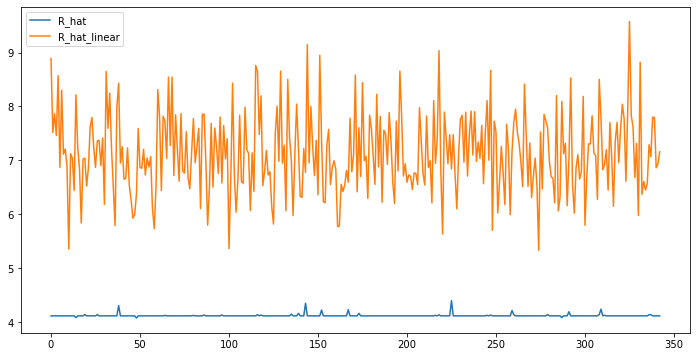

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

players_features[["R_hat", "R_hat_linear"]].plot(figsize=(12,6))

That leaves us with another question, that is which model should we trust? To answer it, we can calculate their performance measures on the training dataset.

In [136]:
from sklearn.model_selection import train_test_split

# split the team runs and features dataset 
X_train, X_test, y_train, y_test = train_test_split(team_features, team_runs, test_size=0.33, random_state=1)

# calculate the accuracy score for Randomforest regression
model.fit(X_train, y_train)
print(f"Randomforest Regression scored: {model.score(X_test,  y_test):.3f}")

# calculate the accuracy score for linear regression
linear_model.fit(X_train, y_train)
print(f"Linear Regression scored: {linear_model.score(X_test,  y_test):.3f}")

Randomforest Regression scored: 0.876
Linear Regression scored: 0.937


We can see that the linear regression actually performed better. So we should trust the draft with the linear model rather than the new Random Forest Regression.